In [1]:
from itertools import count
from IPython.display import clear_output
from pathlib import Path
from time import time, sleep
from line_profiler import LineProfiler
import pickle
from matplotlib import pyplot as plt

In [2]:
%load_ext line_profiler

In [3]:
PATH = Path('./data/last_number.txt')

In [4]:
PATH_CHECKPOINT = Path('./data/Checkpoint.pkl')

 The order of operations is important here in line 9 and 10. We want the first instruction to be the cache access, so the try triggers immediately should we need to go the slow path. At the same time, we need the last bit of N to be shifted into R, and not Q. Otherwise we could overwrite N directly in line 9. This way we need to make a temporary variable, and then write the result into N in line 13 or 15.

We can probably use the remainder to quickly compute additional digits. Since the remainder represents the last few digits of the number anyway, it basically contains all the information we need, but is smaller and thus faster to work with. This could significantly reduce the number of candidates we generate! We can even make this a parameter to change later. So after ever division, we check if the remainder has a 6 at the last digit, and if it does, check the next k digits as well as long as they continue to contain sixes. We could even use the same condition as before, by simply only increasing the counter if all k digits are sixes.

As long as we get cache hits, we actually don't need to compute or store N (or Q as it's sometimes called) at all, since we only ever require the last bit of the previous computation to continue with the next one. Only R is needed for the decision, and that's a fixed size.    
We (probably) do need the entire number in case of a cache miss, since we then need to calculate the actual new values. Although, the cache miss will always happen at the end of the iteration, and should happen in predictable intervals.  
The new number to add to the cache will also always be relatively small. If we add the new number in iteration j, then by definition in iteration j-1 the division result N would have had to have been zero. Then in iteration j, the remainder has grown enough to be larger than D, causing a 1 to be shifted in from the right.


In [5]:
# profiler = LineProfiler()
# @profiler
def count_sixes(D, Cache, k=1):
    SixCounter    = 0
    SixCounterMax = 0
    N = 0
    for (j, R) in enumerate(Cache):
        R = (R << 1) | N
        if R >= D:
            R = R - D
            N = 1
        else:
            N = 0
        Cache[j] = R
        
        Digit = R % 10
        if Digit == 6:
            SixCounter += 1
            if SixCounter == 5:
                R = (Cache[j-1]) // 10
                for _ in range(k):
                    Digit = R % 10
                    if Digit == 6:
                        R = R // 10
                    else:
                        SixCounter = 1
                        break
            SixCounterMax = max(SixCounterMax, SixCounter)
        else:
            SixCounter = 0
    if N > 0:  # assert N == 1
        Cache.append(1)
    return SixCounterMax

### Save and Load State

In [6]:
LastNumber = int(PATH.read_text()); LastNumber

43325000

In [7]:
class checkpoint:
    def __init__(self, LastNumber, Cache):
        self.LastNumber = LastNumber
        self.Cache = Cache

def SaveState(i, Cache):
    PATH.write_text(f'{i}')
    Checkpoint = checkpoint(i, Cache)
    with PATH_CHECKPOINT.open(mode='wb') as f:
        pickle.dump(Checkpoint, f)

def LoadState():
    with PATH_CHECKPOINT.open(mode='rb') as f:
        Checkpoint = pickle.load(f)
    return Checkpoint

In [8]:
Checkpoint = LoadState()

In [9]:
LastNumber = Checkpoint.LastNumber
Cache      = Checkpoint.Cache
Divisor    = 10**399
i          = LastNumber
Number     = 1<<i
LastNumber

43325000

### Rebuild cache

This can be sped up by at least 2x, simply by computing the division and remainder at the same time. As it stands, they are computed separately which is literally just double the work.  
Can we maybe go the other way? Computing the last remainder for when N=0, and then multiply upwards?

In [10]:
def RebuildCache(i:int):
    """If the cache gets corrupted, use this to rebuild it.
    Be warned, this can take along time with sufficiently large i!
    The cache stores results from the previous iteration to speed up the current one,
    meaning that i=1 is the first legal input since i=0 doesn't have a previous iteration."""
    assert i > 0, 'Zero is not a legal input. 1 is the first legal input.'
    N     = 1<<(i - 1)
    D     = 10**399
    Cache = []
    while N > 0:
        R = N  % D
        N = N // D
        Cache.append(R)
    return i, D, Cache

In [13]:
%%time
if 0:
    i, Divisor, Cache = RebuildCache(LastNumber)

CPU times: total: 0 ns
Wall time: 0 ns


In [14]:
profiler.print_stats()

NameError: name 'profiler' is not defined

### Main

In [10]:
def VerifyCache(i, Divisor, Cache):
    'If all of these checks pass, then it should be fine to use these values to continue the search.'
    Number = 1<<(i - 1)
    assert Divisor == 10**399
    assert Number % Divisor == Cache[0]
    j            = len(Cache) - 1
    j0thDivision = Number // (10**(399*(j  )))
    j1thDivision = Number // (10**(399*(j+1)))
    assert j0thDivision != 0
    assert j1thDivision == 0
    assert j0thDivision % Divisor == Cache[j]
    assert Cache[-1] != 0
def ExpensiveVerifyCache(LastNumber, Cache):
    _, _, Cache2 = RebuildCache(LastNumber)
    assert Cache == Cache2

In [11]:
%%time
VerifyCache(i, Divisor, Cache)

CPU times: total: 20.5 s
Wall time: 20.6 s


In [ ]:
%%time
if 0:
    ExpensiveVerifyCache(LastNumber, Cache)

In [12]:
len(Cache)

31801

In [13]:
goliath = 666*'666'
goliath_amount = len(goliath); goliath_amount

1998

In [14]:
# 1995 / 5 = 399 <-------------- This makes about 0.33% of numbers trigger an expensive check
# Exponent    = 399
# fat_divisor = 10**Exponent
candidate_treshold = 5

In [15]:
## WARNING!!!
## This cell can NOT be restarted after a keyboard interrupt due to likely inconsistent cache!
t0 = time()
tt = 1 / 60
CandidatesFound = 0
while True:
    for _ in range(250):
        t1 = time()
        for _ in range(100):
            sixes = count_sixes(Divisor, Cache, k=66)
            if sixes >= candidate_treshold:
                CandidatesFound += 1
                Path(f'./candidates/{i}').touch() # do the expensive check offline
            i += 1
        t2 = time()
        clear_output(wait=True)
        print(i)
        print(f'#Candidates found    : {CandidatesFound}')
        print(f'Cheap Duration (x100): {round((t2 - t1), 3)} seconds')
        print(f'Total Duration       : {round(tt * (t1 - t0), 3)} minutes')
    
    VerifyCache(i, Divisor, Cache)
    SaveState(i, Cache)
    print('Checkpoint saved to disk!')
    sleep(6)
    # break

43325800
#Candidates found    : 0
Cheap Duration (x100): 1.421 seconds
Total Duration       : 306.287 minutes


KeyboardInterrupt: 

In [16]:
i

43325891

In [46]:
VerifyCache(i, Divisor, Cache)

In [25]:
SaveState(i, Cache)

### Profiling cache rebuilding

In [11]:
Steps        = [1, 1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 7000000, 8000000, 9000000, 10000000,
             11000000, 12000000, 13000000, 14000000, 15000000, 16000000, 17000000, 18000000, 19000000,
             20000000, 21000000, 22000000, 23000000, 24000000, 25000000, 26000000, 27000000, 28000000, 29000000,
             30000000, 31000000, 32000000, 33000000, 34000000, 35000000, 36000000, 37000000, 38000000, 39000000, 40000000]
CacheSizes   = [1, 755, 1509, 2264, 3018, 3773, 4527, 5282, 6036, 6791, 7545, 8300, 9054, 9808, 10563,
                11317, 12072, 12826, 13581, 14335, 15090, 15844, 16599, 17353, 18108, 18862, 19616, 20371,
                21125, 21880, 22634, 23389, 24143, 24898, 25652, 26407, 27161, 27916, 28670, 29424, 30179]
SecondsTaken = [0, 1.56, 6.25, 14.19, 25.74, 41.11, 59.59, 81.5, 106.54, 134.97, 164.01, 196.6,
                239.06, 278.46, 325.64, 373.95, 425.8, 479.41, 542.85, 619.86, 691.43, 754.13,
                836.16, 907.51, 968.34, 1033.97, 1108.73, 1198.13, 1288.36, 1349.05, 1480.99,
                1656.84, 1757.66, 1891.89, 1972.1, 1987.71, 2263.23, 2213.12, 2328.01, 2544.09, 2565.07]

TestStepSize = 1_000_000
TestNumber   = 40_000_000

In [13]:
for _ in range(4):
    TestNumber += TestStepSize
    t1 = time()
    _, _, Cache = RebuildCache(TestNumber)
    T  = round(time() - t1, 2)
    Steps       .append(TestNumber)
    CacheSizes  .append(len(Cache))
    SecondsTaken.append(T)
    print(TestNumber, len(Cache), T)

37000000 27916 2213.12
38000000 28670 2328.01
39000000 29424 2544.09
40000000 30179 2565.07


In [ ]:
Steps, CacheSizes, SecondsTaken

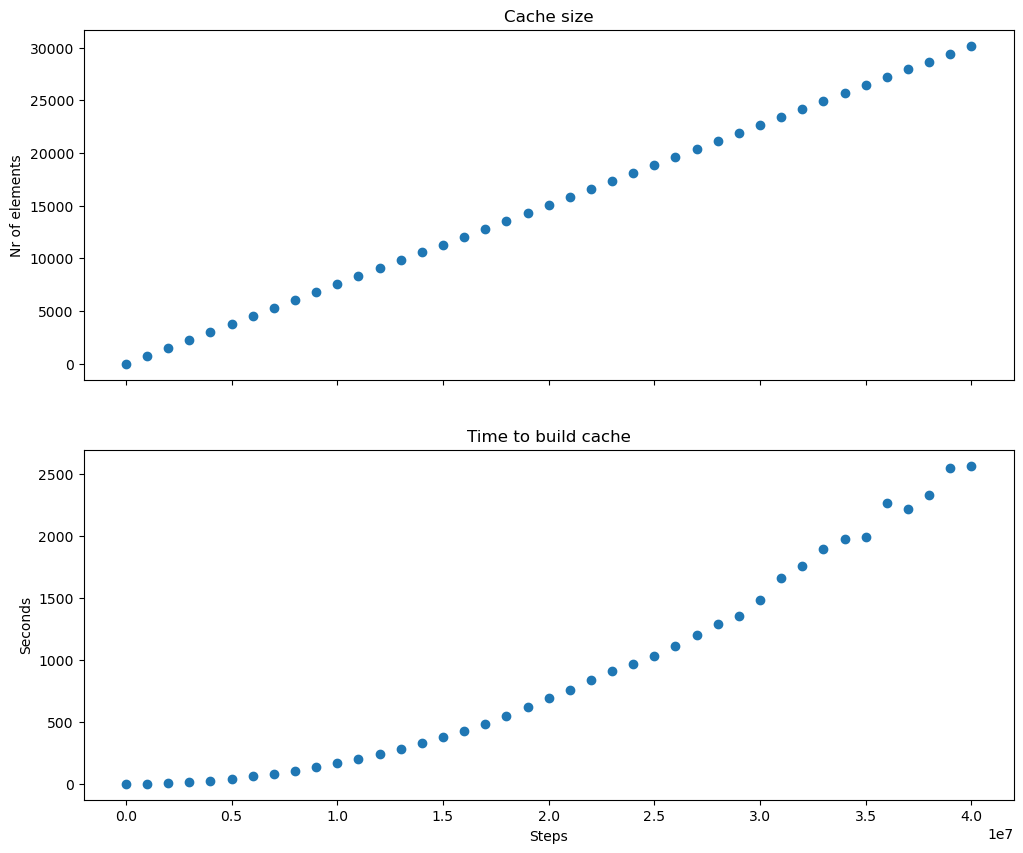

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 10))

ax1.scatter(Steps, CacheSizes)
ax1.set_title('Cache size')
ax1.set_ylabel('Nr of elements')

ax2.scatter(Steps, SecondsTaken)
ax2.set_title('Time to build cache')
ax2.set_xlabel('Steps')
ax2.set_ylabel('Seconds')
plt.show()

### Line Profiling

In [33]:
profiler.print_stats()

Timer unit: 1e-07 s

Total time: 22.1289 s
File: C:\Users\Florian\AppData\Local\Temp\ipykernel_8132\2824720481.py
Function: count_sixes at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profiler
     3                                           def count_sixes(D, Cache, k=1):
     4       410       1679.0      4.1      0.0      SixCounter    = 0
     5       410       1008.0      2.5      0.0      SixCounterMax = 0
     6       410       1077.0      2.6      0.0      N = 0
     7   8650295   26014702.0      3.0     11.8      for (j, R) in enumerate(Cache):
     8   8649886   31220574.0      3.6     14.1          R = (R << 1) | N
     9   8649886   21984430.0      2.5      9.9          if R >= D:
    10   4326044   13783495.0      3.2      6.2              R = R - D
    11   4326044   10553357.0      2.4      4.8              N = 1
    12                                                   else:
    13   4323842   10

In [21]:
profiler.print_stats()

Timer unit: 1e-07 s

Total time: 498.111 s
File: C:\Users\Florian\AppData\Local\Temp\ipykernel_5784\8257369.py
Function: count_sixes at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profiler
     3                                           def count_sixes(D, Cache, k=1):
     4     50000     446787.0      8.9      0.0      SixCounter    = 0
     5     50000     225080.0      4.5      0.0      SixCounterMax = 0
     6     50000     200161.0      4.0      0.0      N = 0
     7     50000     527111.0     10.5      0.0      J = len(Cache)
     8 182654573  487809298.0      2.7      9.8      for j in range(J):
     9 182604573  820338476.0      4.5     16.5          R = (Cache[j] << 1) | N
    10 182604573  461821560.0      2.5      9.3          if R >= D:
    11  91285830  305398528.0      3.3      6.1              R = R - D
    12  91285830  228303883.0      2.5      4.6              N = 1
    13                   

In [43]:
profiler.print_stats()

Timer unit: 1e-07 s

Total time: 71.5721 s
File: C:\Users\Florian\AppData\Local\Temp\ipykernel_3740\811362255.py
Function: count_sixes at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profiler
     3                                           def count_sixes(N, D, Cache, k=1):
     4       500       3752.0      7.5      0.0      SixCounter    = 0
     5       500       1724.0      3.4      0.0      SixCounterMax = 0
     6       500       1216.0      2.4      0.0      j = 0
     7   1355000    3627650.0      2.7      0.5      while N > 0:
     8   1354500    3135707.0      2.3      0.4          try:
     9   1354500   17847447.0     13.2      2.5              Q, R = Cache[j]
    10   1354500    6781471.0      5.0      0.9              R    = (R << 1) | (N & 1)
    11   1354500    3770885.0      2.8      0.5              if R >= D:
    12    677462    2444918.0      3.6      0.3                  R = R - D
    13  

In [37]:
profiler.print_stats()

Timer unit: 1e-07 s

Total time: 80.4808 s
File: C:\Users\Florian\AppData\Local\Temp\ipykernel_3740\811362255.py
Function: count_sixes at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profiler
     3                                           def count_sixes(N, D, Cache, k=1):
     4       500       4088.0      8.2      0.0      SixCounter    = 0
     5       500       1762.0      3.5      0.0      SixCounterMax = 0
     6       500       1806.0      3.6      0.0      j = 0
     7   1355000    3978183.0      2.9      0.5      while N > 0:
     8   1354500    3367363.0      2.5      0.4          try:
     9   1354500   20750070.0     15.3      2.6              Q, R = Cache[j]
    10   1354500    7626254.0      5.6      0.9              R    = (R << 1) | (N & 1)
    11   1354500    3990719.0      2.9      0.5              if R >= D:
    12    677462    2702527.0      4.0      0.3                  R = R - D
    13  

In [31]:
profiler.print_stats()

Timer unit: 1e-07 s

Total time: 82.1128 s
File: C:\Users\Florian\AppData\Local\Temp\ipykernel_3740\811362255.py
Function: count_sixes at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profiler
     3                                           def count_sixes(N, D, Cache, k=1):
     4       500       4156.0      8.3      0.0      SixCounter    = 0
     5       500       1707.0      3.4      0.0      SixCounterMax = 0
     6       500       1381.0      2.8      0.0      j = 0
     7   1355000    3926936.0      2.9      0.5      while N > 0:
     8   1354500    3460942.0      2.6      0.4          try:
     9   1354500   21611697.0     16.0      2.6              Q, R = Cache[j]
    10   1354500    7713463.0      5.7      0.9              R    = (R << 1) | (N & 1)
    11   1354500    3939145.0      2.9      0.5              if R >= D:
    12    677462    2734357.0      4.0      0.3                  R = R - D
    13  

In [52]:
profiler.print_stats()

Timer unit: 1e-07 s

Total time: 285.764 s
File: C:\Users\Florian\AppData\Local\Temp\ipykernel_2860\3149308276.py
Function: count_sixes at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profiler
     3                                           def count_sixes(N, D, Cache):
     4      5000      32379.0      6.5      0.0      SixCounter    = 0
     5      5000      14993.0      3.0      0.0      SixCounterMax = 0
     6      5000      14695.0      2.9      0.0      j = 0
     7   8429120   22667472.0      2.7      0.8      while N > 0:
     8   8424120   20222604.0      2.4      0.7          try:
     9   8424120   79352010.0      9.4      2.8              Q, R = Cache[j]
    10   8424116   41619713.0      4.9      1.5              R    = (R << 1) | (N & 1)
    11   8424116   22725421.0      2.7      0.8              if R >= D:
    12   4206433   15305622.0      3.6      0.5                  R = R - D
    13   420

In [64]:
profiler.print_stats()

Timer unit: 1e-07 s

Total time: 290.674 s
File: C:\Users\Florian\AppData\Local\Temp\ipykernel_2860\454176833.py
Function: count_sixes at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profiler
     3                                           def count_sixes(N, D, Cache):
     4      5000      33996.0      6.8      0.0      SixCounter    = 0
     5      5000      16603.0      3.3      0.0      SixCounterMax = 0
     6      5000      14465.0      2.9      0.0      j = 0
     7   8429120   22883187.0      2.7      0.8      while N > 0:
     8   8424120   20623957.0      2.4      0.7          try:
     9   8424120   18750014.0      2.2      0.6              M    = N
    10   8424120   39660028.0      4.7      1.4              N, R = Cache[j]
    11   8424116   41892683.0      5.0      1.4              R    = (R << 1) | (M & 1)
    12   8424116   23332859.0      2.8      0.8              if R >= D:
    13   4206433  

In [76]:
profiler.print_stats()

Timer unit: 1e-07 s

Total time: 287.01 s
File: C:\Users\Florian\AppData\Local\Temp\ipykernel_2860\896728211.py
Function: count_sixes at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profiler
     3                                           def count_sixes(N, D, Cache):
     4      5000      36689.0      7.3      0.0      SixCounter    = 0
     5      5000      15944.0      3.2      0.0      SixCounterMax = 0
     6      5000      14274.0      2.9      0.0      j = 0
     7   8429120   22576043.0      2.7      0.8      while N > 0:
     8   8424120   19896093.0      2.4      0.7          try:
     9   8424120   25424230.0      3.0      0.9              B    = (N & 1)
    10   8424120   38899041.0      4.6      1.4              N, R = Cache[j]
    11   8424116   35478098.0      4.2      1.2              R    = (R << 1) | B
    12   8424116   23199341.0      2.8      0.8              if R >= D:
    13   4206433   

In [23]:
profiler.print_stats()

Timer unit: 1e-07 s

Total time: 196.47 s
File: C:\Users\Florian\AppData\Local\Temp\ipykernel_5288\3149308276.py
Function: count_sixes at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profiler
     3                                           def count_sixes(N, D, Cache):
     4      5000      34920.0      7.0      0.0      SixCounter    = 0
     5      5000      20895.0      4.2      0.0      SixCounterMax = 0
     6      5000      15779.0      3.2      0.0      j = 0
     7   6957875   18427489.0      2.6      0.9      while N > 0:
     8   6952875   16604115.0      2.4      0.8          try:
     9   6952875   56842157.0      8.2      2.9              Q, R = Cache[j]
    10   6952872   33545428.0      4.8      1.7              R    = (R << 1) | (N & 1)
    11   6952872   18737501.0      2.7      1.0              if R >= D:
    12   3474592   12804653.0      3.7      0.7                  R = R - D
    13   3474

In [55]:
profiler.print_stats()

Timer unit: 1e-07 s

Total time: 869.917 s
File: C:\Users\Florian\AppData\Local\Temp\ipykernel_1912\369381277.py
Function: count_sixes at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profiler
     3                                           def count_sixes(N, D, Cache):
     4      5001      44272.0      8.9      0.0      SixCounter    = 0
     5      5001      19684.0      3.9      0.0      SixCounterMax = 0
     6      5001      17250.0      3.4      0.0      j = 0
     7   6618373   21280476.0      3.2      0.2      while N > 0:
     8                                                   # TODO: Could divide first, which would allow us to remove the (j+1) from the divisor.
     9                                                   # TODO: use continued division for this as well? Or can't we just use the remainder instead of the number?
    10   6613373 6513440895.0    984.9     74.9          Digit = N % 10
    11

In [131]:
profiler.print_stats()

Timer unit: 1e-07 s

Total time: 6860.08 s
File: C:\Users\Florian\AppData\Local\Temp\ipykernel_7708\2766715933.py
Function: count_sixes at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profiler
     3                                           def count_sixes(Number, Divisors, Cache):
     4     49999     331421.0      6.6      0.0      SixCounter    = 0
     5     49999     134709.0      2.7      0.0      SixCounterMax = 0
     6     49999     153801.0      3.1      0.0      j = 0
     7     49999     137143.0      2.7      0.0      N = Number
     8  53829177  150020560.0      2.8      0.2      while N > 0:
     9  53779178        4e+10    740.6     58.1          Digit = N % 10
    10  53779178  148807493.0      2.8      0.2          if Digit == 6:
    11   5385654   16825128.0      3.1      0.0              SixCounter   += 1
    12   5385654   39580574.0      7.3      0.1              SixCounterMax = max(SixCo

In [84]:
profiler.print_stats()

Timer unit: 1e-07 s

Total time: 22106.9 s
File: C:\Users\Florian\AppData\Local\Temp\ipykernel_12220\4211618779.py
Function: count_sixes at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profiler
     3                                           def count_sixes(Number, Divisors, Cache):
     4    195347    1271589.0      6.5      0.0      SixCounter    = 0
     5    195347     629752.0      3.2      0.0      SixCounterMax = 0
     6    195347     448973.0      2.3      0.0      i = 0
     7    195347     554875.0      2.8      0.0      N = Number
     8 192232259  547501112.0      2.8      0.2      while N > 0:
     9 192036912        1e+11    672.5     58.4          Digit = N % 10
    10 192036912  528765814.0      2.8      0.2          if Digit == 6:
    11  19237145   59780868.0      3.1      0.0              SixCounter   += 1
    12  19237145  139016938.0      7.2      0.1              SixCounterMax = max(SixC

In [43]:
profiler.print_stats()

Timer unit: 1e-07 s

Total time: 94.5 s
File: C:\Users\Florian\AppData\Local\Temp\ipykernel_12220\4211618779.py
Function: count_sixes at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profiler
     3                                           def count_sixes(Number, Divisors, Cache):
     4      1000       6186.0      6.2      0.0      SixCounter    = 0
     5      1000       2747.0      2.7      0.0      SixCounterMax = 0
     6      1000       2364.0      2.4      0.0      i = 0
     7      1000       3094.0      3.1      0.0      N = Number
     8    902424    2429788.0      2.7      0.3      while N > 0:
     9    901424  553922105.0    614.5     58.6          Digit = N % 10
    10    901424    2409905.0      2.7      0.3          if Digit == 6:
    11     90467     277185.0      3.1      0.0              SixCounter   += 1
    12     90467     679282.0      7.5      0.1              SixCounterMax = max(SixCoun

In [33]:
profiler.print_stats()

Timer unit: 1e-07 s

Total time: 95.9172 s
File: C:\Users\Florian\AppData\Local\Temp\ipykernel_12220\3907487493.py
Function: count_sixes at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profiler
     3                                           def count_sixes(Number, Divisors, Cache):
     4      1000       7890.0      7.9      0.0      SixCounter    = 0
     5      1000       3153.0      3.2      0.0      SixCounterMax = 0
     6      1000       2561.0      2.6      0.0      i = 0
     7      1000       2442.0      2.4      0.0      N = Number
     8    901749    2333698.0      2.6      0.2      while N > 0:
     9    900749  557088560.0    618.5     58.1          Digit = N % 10
    10    900749    2485078.0      2.8      0.3          if Digit == 6:
    11     90253     288829.0      3.2      0.0              SixCounter   += 1
    12     90253     715613.0      7.9      0.1              SixCounterMax = max(SixC

In [15]:
profiler.print_stats()

Timer unit: 1e-07 s

Total time: 2697.76 s
File: C:\Users\Florian\AppData\Local\Temp\ipykernel_1796\3027381636.py
Function: count_sixes at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profiler
     3                                           def count_sixes(Number, Divisors, Cache):
     4     94909     681102.0      7.2      0.0      SixCounter    = 0
     5     94909     338009.0      3.6      0.0      SixCounterMax = 0
     6     94909     249670.0      2.6      0.0      i = 0
     7     94909     301435.0      3.2      0.0      N = Number
     8  44363833  118510216.0      2.7      0.4      while N > 0:
     9  44268925        1e+10    329.3     54.0          Digit    = N % 10
    10  44268925  665760860.0     15.0      2.5          Divisor  = Divisors[i]
    11  44268925  122325401.0      2.8      0.5          if i in Cache:
    12  44268423  317412938.0      7.2      1.2              Q, R = Cache[i]
    1